In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import json
import sklearn
from sklearn.model_selection import train_test_split
import joblib

#imports for random forest
from sklearn.ensemble import RandomForestClassifier

# imports for KNN
from sklearn.neighbors import KNeighborsClassifier

#imports for LSTM
from numpy import zeros, newaxis
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from keras import regularizers
from keras import Input
from keras.layers import Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed, Dropout
from pandas.core.describe import describe_timestamp_as_categorical_1d

2023-02-16 23:07:31.341486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 23:07:35.206053: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-16 23:07:35.206095: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-16 23:07:46.842332: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [2]:
"""
Classes:
  1. Data Processor
  2. Random Forest (RF)
  3. Long Short Term Memory (LSTM)
  4. K Nearest Nieghbors (KNN)
  5. Model Trainer
"""

class Data_Processor():
    def __init__(self):
        self.user_types = ["worker", "student", "senior_citizen"]
        self.noise_types = ["small", "mid", "large"]
        self.has_pet = [True, False]
        self.has_plant = [True, False]
        self.sleep_temp = [x for x in range(60, 68)]
        self.noise_value = {"small": random.uniform(-1, 1), "mid": random.uniform(-1,2), "large": random.uniform(-2, 3)}
        self.days_of_week = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6}
        self.seasonal_temp = {1: 68, 2: 75, 3: 78, 4: 72}# 1-winter 2-spring 3-summer 4-fall
        
    # convert to celsius
    def ftc(self,temp):
        return (temp - 32) * 5/9
    
    # convert to fahrenheit
    def ctf(self,temp):
        return temp * 9/5 + 32

    def set_internal_temp(self, row, data, user_profile):
        col, factor = (2, "external_temp") if data[row, 4] == -99 else (4, "ac_temp")
        if row == 0:
            data[row, 5] = data[row, col]
        else:
            delta = (data[row, col] - data[row-1, 5]) / (user_profile["insolation_time"][factor]*60)
            data[row, 5] = data[row-1, 5] + delta

    def format_data(self, data_df):
        data_df.columns = ['WBANNO', 'UTC_DATE', 'UTC_TIME', 'LST_DATE', 'LST_TIME', 'CRX_VN', 'LONGITUDE', 'LATITUDE', 'AIR_TEMPERATURE',
                        'PRECIPITATION', 'SOLAR_RADIATION', 'SR_FLAG', 'SURFACE_TEMPERATURE', 'ST_TYPE', 'ST_FLAG', 'RELATIVE_HUMIDITY',
                        'RH_FLAG', 'SOIL_MOISTURE_5', 'SOIL_TEMPERATURE_5', 'WETNESS', 'WET_FLAG', 'WIND_1_5', 'WIND_FLAG']
        # drop useless columns
        data_df.drop(['WBANNO', 'LST_DATE', 'LST_TIME', 'CRX_VN', 'PRECIPITATION', 'SR_FLAG', 'SOLAR_RADIATION', 'SURFACE_TEMPERATURE',
                    'SOIL_MOISTURE_5', 'SOIL_TEMPERATURE_5', 'LONGITUDE', 'LATITUDE', 'ST_TYPE', 'ST_FLAG', 'RH_FLAG', 'WETNESS',
                    'WET_FLAG', 'WIND_1_5', 'WIND_FLAG'], axis=1, inplace=True)
        # rename columns
        data_df.rename(columns={"AIR_TEMPERATURE": "EXTERNAL_TEMP"}, inplace=True)
        data_df.rename(columns={"RELATIVE_HUMIDITY": "OUTSIDE_HUMIDITY"}, inplace=True)
        data_df.rename(columns={"UTC_DATE": "DATE"}, inplace=True)
        data_df.rename(columns={"UTC_TIME": "TIME"}, inplace=True)
        # format date and time
        unformated_date_time = data_df[['DATE', 'TIME']].to_numpy()
        data_df['DATE'] = data_df['DATE'].apply(lambda x: '{0:0>8}'.format(x))
        data_df['DATE'] = pd.to_datetime(data_df['DATE'], format='%Y%m%d')
        data_df['TIME'] = data_df['TIME'].apply(lambda x: '{0:0>4}'.format(x))
        data_df['TIME'] = pd.to_datetime(data_df['TIME'], format='%H%M').dt.time
        return data_df.to_numpy(), unformated_date_time

    def save_data(self, data, user_profile):
        if not os.path.exists('data'):
            os.makedirs('data')
        np.save(f'data/processed_data.npy', data)
        # save user profile as txt
        with open(f'data/user_profile_{user_profile["user_type"]}.txt', 'w') as f:
            f.write(json.dumps(user_profile))
        return

    # generate random day events
    def gen_schedule(self, first_event, num_events, noise_type):
        for i in range(num_events+2):
            end_value = 0
            if i == 0:  # first block is sleep
                start, end = -1, 6
            elif i == 1:  # next blocks are work
                start, end = max(first_event[0], end_value), first_event[1]
            elif i == num_events+1:  # last block is sleep
                start, end = max(22, end_value), float('inf')
            # random intervals within bounds
            noise = self.noise_value[noise_type]
            start_value = int(min(23, max(random.uniform(start-noise, start+noise), 0)))
            end_value = int(min(23, max(random.uniform(end-noise, end+noise), 0)))
            # catch errors
            if start_value == end_value and start_value == 23:
                start_value, end_value = start_value-1, end_value
            elif start_value == end_value:
                start_value, end_value = start_value, end_value+1
            start = end + 2
            end = start + random.randint(2, 3)
            yield (start_value, end_value)

    # generate random profile
    def gen_user_profile(self, user_type=None, noise_type=None, pets=None, plants=None, insolation_time_ac=None, insolation_time_external=None, schedule_cycle=None):
        profile = {"user_type": user_type if user_type else random.choice(self.user_types),
                "noise_type": noise_type if noise_type else random.choice(self.noise_types),
                "pets": pets if pets else random.choice(self.has_pet),
                "plants": plants if plants else random.choice(self.has_plant),
                "sleep_temp": random.choice(self.sleep_temp),
                "insolation_time": {"ac_temp": insolation_time_ac if insolation_time_ac else random.uniform(1, 0.1),
                                    "external_temp": insolation_time_external if insolation_time_external else random.uniform(1, 0.1)}}
        num_days = schedule_cycle if schedule_cycle else 7
        # monday=0, tuesday=1, wednesday=2, thursday=3, friday=4, saturday=5, sunday=6
        schedule = []
        for day in range(num_days):
            first_event = (7, 10)
            num_events = random.randint(1, 4)
            gen_day = list(self.gen_schedule((7, 16), 1, profile["noise_type"])) if profile["user_type"] == "worker" and day % 7 < 5 else list(self.gen_schedule(first_event, num_events, profile["noise_type"]))
            if profile["user_type"] == "student":
                if day % 7 in (5, 6):
                    day_schedule = gen_day
                elif day % 7 in (1, 3):
                    day_schedule = gen_day if day % 7 == 1 else copy_tuesday
                    copy_tuesday = day_schedule
                elif day % 7 in (0, 2, 4):
                    day_schedule = gen_day if day % 7 == 0 else copy_monday
                    copy_monday = day_schedule
            else:
                day_schedule = gen_day
            schedule.append(day_schedule)
        profile["schedule"] = schedule
        return profile

    def process_data(self, filename, user_profile,quick = False):
        # process data Date=0, Time=1, Outside Temp=2, Outside Humidity=3, AC_TEMP=4, INTERNAL_TEMP=5, AI_CHANGE=6, USER_CHANGE=7, DAY_OF_WEEK=8, SEASON=9
        raw_data_df = pd.read_csv(filename+'.txt', sep='\s+', header=None)

        # convert raw_data to numpy array data
        data, unformated_date_time = self.format_data(raw_data_df)
        # add new columns on end
        data = np.hstack((data, np.full((len(data), 6), None)))
        # initializes variables
        current_sleep_temp = self.ftc(user_profile["sleep_temp"])
        current_pet_temp = random.uniform(self.ftc(64), self.ftc(78))
        current_plant_temp = random.uniform(self.ftc(60), self.ftc(75))
        current_season_temp = self.ftc(self.seasonal_temp[data[0][0].month % 12 // 3 + 1] + self.noise_value[user_profile["noise_type"]])
        current_ac_delay = user_profile["insolation_time"]["ac_temp"] * 2 + 0.5*self.noise_value[user_profile["noise_type"]]
        day_index = self.days_of_week[data[0, 0].day_name()]
        event_stack = user_profile["schedule"][day_index]
        event_status = "starting"
        for row in range(len(data)):
            # set default values
            data[row, 4:10] = [-99, -99, 0, 0, day_index%7, data[row, 0].month % 12 // 3 + 1]
            event = event_stack[0]
            # update values based on time
            if row != 0:
                if data[row, 0].day != data[row-1, 0].day:  # new day
                    day_index += 1
                    event_stack = user_profile["schedule"][day_index % len(user_profile["schedule"])]
                if data[row, 9] != data[row-1, 9]:  # new season
                    current_season_temp = self.ftc(self.seasonal_temp[data[row, 9]] + self.noise_value[user_profile["noise_type"]])
                    current_plant_temp += self.noise_value[user_profile["noise_type"]]
                if data[row, 0].month != data[row-1, 0].month:  # new month
                    current_sleep_temp += self.noise_value[user_profile["noise_type"]]
                    if data[row, 0].month % 3 == 0:
                        current_pet_temp += self.noise_value[user_profile["noise_type"]]
            # check event status relative to time
            if event[0] == data[row, 1].hour:
                event_status = "starting"
            elif event[0] < data[row, 1].hour < event[1] - current_ac_delay:
                event_status = "happening"
            elif event[1]-current_ac_delay <= data[row, 1].hour <= event[1]:
                event_status = "ending"
            elif event[1] < data[row, 1].hour:
                if len(event_stack) > 1:
                    event_stack = event_stack[1:]
                    event = event_stack[0]
                    event_status = "starting" if event[0] == data[row, 1].hour else "ending"
            # set ac temp based on current event
            if event[0] == 0 or event[1] == 23:  # (sleep,23)(0, wake_up_time)
                if event[0] == 0 and event_status == "ending":
                    data[row, 4] = current_season_temp
                    data[row, 7] = 1 if data[row, 1].minute == 0 else 0
                else:
                    data[row, 4] = current_sleep_temp
                    data[row, 7] = 1 if (event[1], event_status, 0) == (23, "starting", data[row, 1].minute) else 0
            else:  # (event_start, event_end)
                if event_status in ["starting", "happening"]:
                    if user_profile["pets"] and user_profile["plants"]:
                        data[row, 4] = (current_pet_temp + current_plant_temp)/2
                    elif user_profile["pets"] or user_profile["plants"]:
                        data[row, 4] = current_plant_temp if user_profile["plants"] else current_pet_temp
                    else:
                        data[row, 4] = -99
                    data[row, 7] = 1 if (event_status, 0) == ("starting", data[row, 1].minute) else 0
                elif event_status == "ending":
                    data[row, 4] = current_season_temp
                    data[row, 7] = 1 if (
                        event[1]-current_ac_delay, 0) == (data[row, 1].hour, data[row, 1].minute) else 0
            # set internal temp
            self.set_internal_temp(row, data, user_profile)
        # concat raw date time
        data = np.hstack((unformated_date_time[:, :], data[:, [2, 3, 4, 5, 6, 7, 8, 9]]))
        # save data
        if not quick:
            self.save_data(data, user_profile)
        return data

    # plot data
    def plot_data(self, processed_data_df, user_profile, show_ac_temp=True, show_inside_temp=True, show_outside_temp=True, convert=True, time_type="day"):
        print("user_type: ", user_profile["user_type"])
        print("noise_type: ", user_profile["noise_type"])
        print("pets: ", user_profile["pets"])
        print("plants: ", user_profile["plants"])
        print("insolation_time: ", user_profile["insolation_time"])
        x_axis_label = {"day": 288, "week": 7*288, "month": 288*7*4, "year": 288*52*7}
        # if ac temp is -99, replace 0
        processed_data_df = processed_data_df.replace(-99, 0)
        # filter outlines >-20
        processed_data_df = processed_data_df[processed_data_df['AC Temp'] > -20]
        processed_data_df = processed_data_df[processed_data_df['Internal Temp'] > -20]
        processed_data_df = processed_data_df[processed_data_df['External Temp'] > -20]
        # plot data
        y = None
        plt.figure(figsize=(20, 10))
        if show_ac_temp:
            if convert:
                y = self.ctf(processed_data_df['AC Temp'][:x_axis_label[time_type]])
            else:
                y = processed_data_df['AC Temp'][:x_axis_label[time_type]]
            plt.plot(y, label="AC Temp", color="red")
        if show_inside_temp:
            if convert:
                y = self.ctf(processed_data_df['Internal Temp']
                        [:x_axis_label[time_type]])
            else:
                y = processed_data_df['Internal Temp'][:x_axis_label[time_type]]
            plt.plot(y, label="Internal Temp", color="blue")
        if show_outside_temp:
            if convert:
                y = self.ctf(processed_data_df['External Temp'][:x_axis_label[time_type]])
            else:
                y = processed_data_df['External Temp'][:x_axis_label[time_type]]
            plt.plot(y, label="External Temp", color="green")
        plt.legend()
        plt.show()


class Model_RF(): 
    def __init__(self):
        # create default model
        self.model = None

    def format_data(self, data):
        inputs, labels = data[:, [0,1,2,3,5,6,7,8,9]], data[:, 4].astype(int)
        return inputs, labels

    def train(self, hp, data):
        train, val = train_test_split(data, test_size=0.2, shuffle=False)
        x_train, y_train = self.format_data(train)
        x_val, y_val = self.format_data(val)
        #reset and train model
        self.model = RandomForestClassifier(max_features=hp["max_features"]["values"][hp["max_features"]["index"]],
                                            max_depth=hp["max_depth"]["values"][hp["max_depth"]["index"]],
                                            min_samples_split=hp["min_samples_split"]["values"][hp["min_samples_split"]["index"]],
                                            min_samples_leaf=hp["min_samples_leaf"]["values"][hp["min_samples_leaf"]["index"]])
        self.model.fit(x_train, y_train)
        #cross validate models acc
        acc = self.model.score(x_val, y_val)
        return acc

    def test(self, data):
        #test models acc
        x_test, y_test = self.format_data(data)
        acc = self.model.score(x_test, y_test)
        return acc
        
    def predict(self, data):
        #give model prediction and actual value
        inputs, labels = self.format_data(data[:3000])
        predictions = self.model.predict(inputs)
        return predictions, labels

    def load(self, filename):
        # load model 
        self.model = joblib.load(filename)

    def save(self, filename):
        # save model
        if not os.path.exists('models/rf'):
            os.makedirs('models/rf')
        joblib.dump(self.model, 'models/rf'+filename)


class Model_LSTM():
    def __init__(self):
        # create default model
        self.model = None
        self.history = None

    def format_data(self, data):
        timesteps = 50
        # drop date time column
        data = data[:,2:]
        data = data[:3000,:]
        data = data[:len(data) - len(data) % timesteps]
        #one hot encode col 6 and 7 using dataframe
        df = pd.DataFrame(data, columns=['External Temp', 'Outside Humidity', 'AC Temp', 'Internal Temp', 'AI Change', 'User Change', 'Day of Week', 'Season'])
        df['Day of Week'] = pd.Categorical(df['Day of Week'].astype(str), categories=['0', '1', '2', '3', '4', '5', '6'])
        df = pd.get_dummies(df, columns=['Day of Week'])
        df['Season'] = pd.Categorical(df['Season'].astype(str), categories=['1', '2', '3', '4'])
        df = pd.get_dummies(df, columns=['Season'])
        # Normalize numeric data
        norm_col = ['External Temp', 'Outside Humidity', 'AC Temp', 'Internal Temp']
        df[norm_col] = (df[norm_col] - df[norm_col].mean()) / df[norm_col].std()
        data = df.to_numpy()
        x_data, y_data = data[:, [0,1,3,4,5,6,7]], data[:, 2]
        x_data = np.reshape(x_data, (int(x_data.shape[0]/timesteps), timesteps, x_data.shape[1]))
        y_data = np.reshape(y_data, (y_data.shape[0], 1, 1))
        y_data = np.reshape(y_data, (int(y_data.shape[0]/timesteps), timesteps, 1))
        return x_data.astype('float32'), y_data.astype('float32')

    def train(self, hp, data, batch_size=64, epochs=100):
        train, val = train_test_split(data, test_size=0.2, shuffle=False)
        x_train, y_train = self.format_data(train)
        x_val, y_val = self.format_data(val)
        # train model
        self.model = Sequential(name="LSTM-Model")  # Model
        self.model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(units=1, activation='linear'))  # Output Layer
        # self.model.summary()
        self.model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.MeanAbsoluteError()])
        self.history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=2, shuffle=False)
        # cross validate models acc
        acc = self.history.history['val_loss'][-1]
        return acc

    def test(self, data):
        #test models acc
        x_test, y_test = self.format_data(data)
        acc = self.model.evaluate(x_test, y_test, batch_size=128)[1]
        return acc
      
    def predict(self, data):
        #give model prediction and actual value
        inputs, labels = self.format_data(data)
        predictions = self.model.predict(inputs)
        return predictions, labels

    def load(self, filename):
        # load model
        self.model = joblib.load(filename)

    def save(self, filename):
        # save model
        if not os.path.exists('models/lstm'):
            os.makedirs('models/lstm')
        joblib.dump(self.model, 'models/lstm'+filename)


class Model_KNN():
    def __init__(self):
        # create default model
        self.model = None

    def format_data(self, data):
        inputs, labels = data[:, [0,1,2,3,5,6,7,8,9]], data[:, 4].astype(int)
        # fill nan in x with mean
        inputs = np.nan_to_num(inputs, nan=np.nanmean(inputs))
        return inputs, labels

    def train(self, hp, data):
        train, val = train_test_split(data, test_size=0.2, shuffle=False)
        x_train, y_train = self.format_data(train)
        x_val, y_val = self.format_data(val)
        # reset and train model
        self.model = KNeighborsClassifier(n_neighbors=hp["n_neighbors"]["values"][hp["n_neighbors"]["index"]],
                                          weights=hp["weights"]["values"][hp["weights"]["index"]],
                                          algorithm=hp["algorithm"]["values"][hp["algorithm"]["index"]],
                                          leaf_size=hp["leaf_size"]["values"][hp["leaf_size"]["index"]],
                                          p=hp["p"]["values"][hp["p"]["index"]])
        self.model.fit(x_train, y_train)
        # cross validate models acc
        acc = self.model.score(x_val, y_val)
        return acc

    def test(self, data):
        # test models acc
        x_test, y_test = self.format_data(data)
        acc = self.model.score(x_test, y_test)
        return acc

    def predict(self, data):
        #give model prediction and actual value
        inputs, labels = self.format_data(data)
        predictions = self.model.predict(inputs)
        return predictions, labels

    def load(self, filename):
        # load model
        self.model = joblib.load(filename)

    def save(self, filename):
        # save model
        if not os.path.exists('models/knn'):
            os.makedirs('models/knn')
        joblib.dump(self.model, 'models/knn'+filename)


class Model_Trainer():
    def tune_model(self, model_type, hyper_params, data):
        results = {param_name: None for param_name in hyper_params.keys()}
        x, y = [], []
        if model_type == "rf":
            model = Model_RF()
        elif model_type == "lstm":
            model = Model_LSTM()
            self.last_lstm = model.train(hyper_params, data)
            self.plot_loss(model.history)
            return
        elif model_type == "knn":
            model = Model_KNN()
            
        for param_name, param_vals in hyper_params.items():
            # store default value before its updated
            default_index = hyper_params[param_name]["index"]
            for index in range(len(param_vals["values"])):
                # current hyper-parameter value
                hyper_params[param_name]["index"] = index
                # train
                accuracy = model.train(hyper_params, data)
                # store value to list
                x.append(hyper_params[param_name]["values"][index])
                y.append(accuracy)
            # store list to results
            results[param_name] = (x, y)
            x, y = [], []
            # reset default value
            hyper_params[param_name]["index"] = default_index
        self.plot_results(results)  

    def train_model(self, model_type, hyper_params, dev_data, test_data):
        if model_type == "rf":
            print("\n\nRandom Forest model:")
            model = Model_RF()
        elif model_type == "knn":
            print("\n\nKNN model:")
            model = Model_KNN()
        elif model_type == "lstm":
            print("\n\nLSTM model:")
            model = Model_LSTM()
        acc = model.train(hyper_params, dev_data)
        predictions, labels = model.predict(test_data)
        self.plot_prediction(predictions, labels, time_range = "week")
        print("Validation accuracy:",acc)
        acc = model.test(test_data)
        print("Test accuracy:",acc)
        return model
    
    def plot_results(self, results):
        for x_param, (x, y) in results.items():
            plt.plot(x, y)
            plt.xlabel(x_param)
            plt.ylabel("Accuracy")
            plt.title("Accuracy vs "+x_param)
            plt.show()

    def plot_prediction(self, predictions, labels, time_range = "week"):
        time = {"day": 288, "week": 7*288, "month": 288*7*4, "year": 288*52*7}
        plt.plot(predictions[:time[time_range]].flatten())
        plt.plot(labels[:time[time_range]].flatten())
        plt.title('model prediction VS actual')
        plt.legend(['prediction', 'actual'], loc='upper left')
        plt.show()

    def plot_loss(self, history):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        return


Processor = Data_Processor()
RF_model = Model_RF()
LSTM_model = Model_LSTM()
KNN_model = Model_KNN()
Trainer = Model_Trainer()

RF_type = "rf"
LSTM_type = "lstm"
KNN_type = "knn"

RF_hp = {"max_features": {"values": [], "index": 0}, "max_depth": {"values": [], "index": 0}, "min_samples_split": {"values": [], "index": 0}, "min_samples_leaf": {"values": [], "index": 0}}
LSTM_hp = {"hyper_param_name": {"values": [], "index": 0}}
KNN_hp = {"n_neighbors": {"values": [], "index": 0}, "weights": {"values": [], "index": 0}, "algorithm": {"values": [], "index": 0}, "leaf_size": {"values": [], "index": 0},"p": {"values": [], "index": 0}}

In [3]:

"""
READ ME 

1st collect data from link and store in txt file named raw_data
#       Link: https://www.ncei.noaa.gov/access/crn/qcdatasets.html

2nd set user profile as desired: if None selection is random
#       user_type : "worker", "student", "senior_citzen" 
#       noise_type: "small", "mid", "large"
#       pets      : True, False
#       plants    : True, False
#       insolation_time_ac: 1-0 
#       insolation_time_external: 1-0
#       schedule_cycle: 1-356 (default 7)

3rd select batch size and set batch variable to specfic batch
#       e.g batch : week_batch, month_batch, year_batch

4th run this cell.
"""
# generate random user profiles: EDIT ME
user_profile = Processor.gen_user_profile( user_type=None, 
                                                noise_type=None, 
                                                pets=True, 
                                                plants = True,
                                                insolation_time_ac=None, 
                                                insolation_time_external=None,
                                                schedule_cycle = 30)
#process data
processed_data = Processor.process_data("raw_data",user_profile)
#split  Dev, Test
Dev, Test = train_test_split(processed_data, test_size=0.2, shuffle=False)


In [4]:
"""
View Raw Data
"""
#convert txt to csv file
raw_data = pd.read_csv('raw_data.txt', sep='\s+', header=None)
raw_data.columns = ['WBANNO', 'UTC_DATE', 'UTC_TIME', 'LST_DATE', 'LST_TIME', 'CRX_VN', 'LONGITUDE', 'LATITUDE', 'AIR_TEMPERATURE', 'PRECIPITATION', 'SOLAR_RADIATION', 'SR_FLAG', 'SURFACE_TEMPERATURE', 'ST_TYPE', 'ST_FLAG', 'RELATIVE_HUMIDITY', 'RH_FLAG', 'SOIL_MOISTURE_5', 'SOIL_TEMPERATURE_5', 'WETNESS', 'WET_FLAG', 'WIND_1_5', 'WIND_FLAG']
raw_data.to_csv('raw_data.csv', index=False)
#read csv file
df = pd.read_csv('raw_data.csv')
df.head()

,WBANNO,UTC_DATE,UTC_TIME,LST_DATE,LST_TIME,CRX_VN,LONGITUDE,LATITUDE,AIR_TEMPERATURE,PRECIPITATION,...,ST_TYPE,ST_FLAG,RELATIVE_HUMIDITY,RH_FLAG,SOIL_MOISTURE_5,SOIL_TEMPERATURE_5,WETNESS,WET_FLAG,WIND_1_5,WIND_FLAG
0,3739,20160101,5,20151231,1905,2.422,-75.93,37.29,11.2,0.0,...,C,0,87,0,0.229,13.8,1042,0,0.76,0
1,3739,20160101,10,20151231,1910,2.422,-75.93,37.29,11.2,0.0,...,C,0,86,0,0.229,13.8,1042,0,0.79,0
2,3739,20160101,15,20151231,1915,2.422,-75.93,37.29,11.3,0.0,...,C,0,86,0,0.230,13.8,1042,0,0.85,0
3,3739,20160101,20,20151231,1920,2.422,-75.93,37.29,11.3,0.0,...,C,0,87,0,0.229,13.8,1042,0,0.74,0
4,3739,20160101,25,20151231,1925,2.422,-75.93,37.29,11.3,0.0,...,C,0,87,0,0.230,13.8,1042,0,0.49,0


In [5]:
"""
View Preprocessed Data
"""
Dev_df = pd.DataFrame(Dev, columns=['Date', 'Time', 'External Temp', 'Outside Humidity', 'AC Temp', 'Internal Temp', 'AI Change', 'User Change', 'Day of Week', 'Season'])
Dev_df.head()

,Date,Time,External Temp,Outside Humidity,AC Temp,Internal Temp,AI Change,User Change,Day of Week,Season
0,20160101,5,11.2,87,18.888889,18.888889,0,0,4,1
1,20160101,10,11.2,86,18.888889,18.888889,0,0,4,1
2,20160101,15,11.3,86,18.888889,18.888889,0,0,4,1
3,20160101,20,11.3,87,18.888889,18.888889,0,0,4,1
4,20160101,25,11.3,87,18.888889,18.888889,0,0,4,1


user_type:  worker
noise_type:  small
pets:  True
plants:  True
insolation_time:  {'ac_temp': 0.7133805671007538, 'external_temp': 0.5892626302590257}


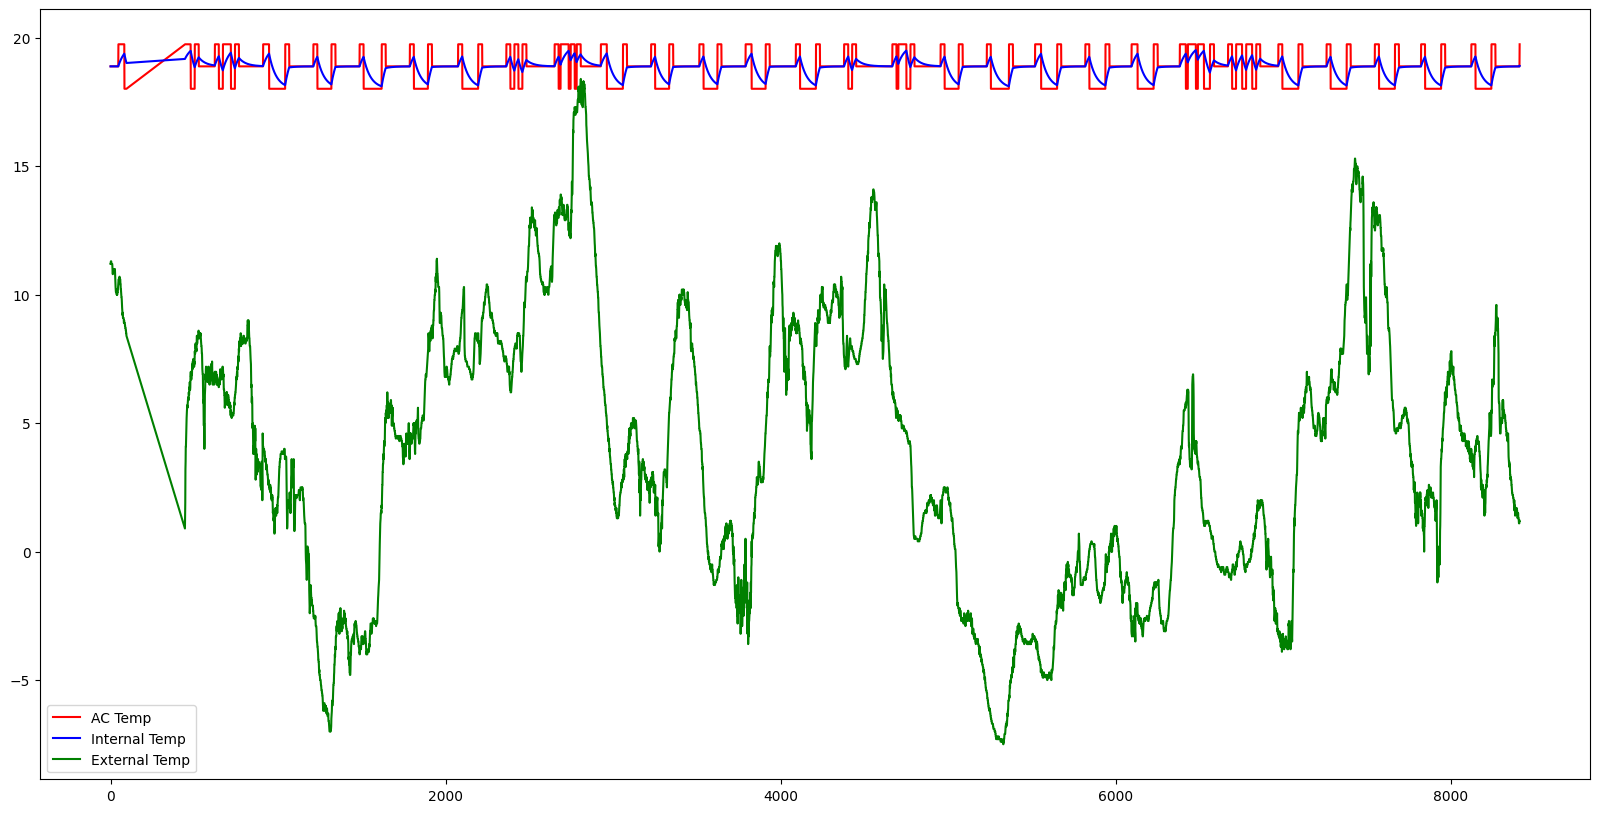

In [6]:
"""
Plot Preprocessed Data
"""
time = "month"
Processor.plot_data(Dev_df, user_profile, show_ac_temp=True, show_inside_temp=True, show_outside_temp=True, convert = False, time_type = time)

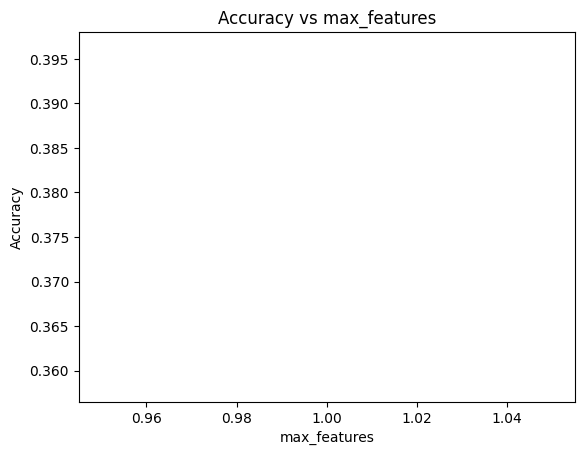

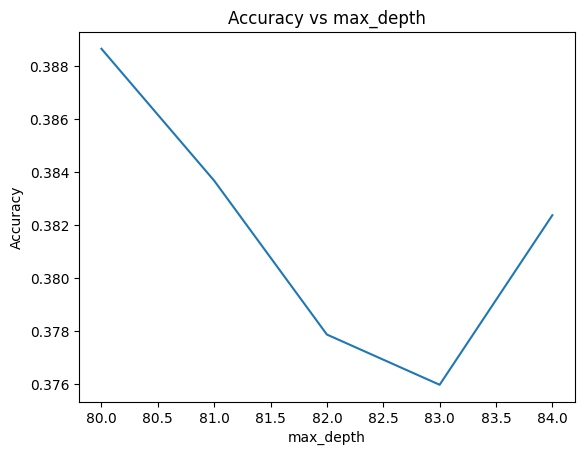

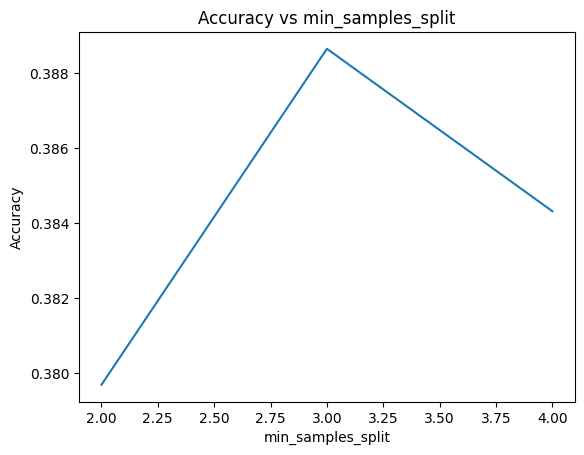

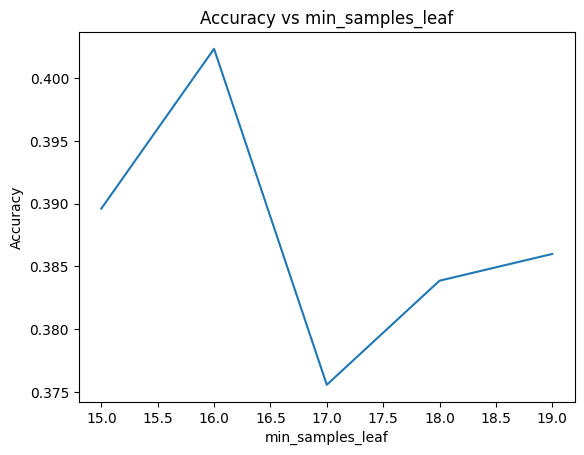

In [7]:
"""
Tune Models Hyper-Parameters
"""
RF_hp["max_features"]["values"] = np.arange(start=1, stop=2, step=1)
RF_hp["max_depth"]["values"] = np.arange(start=80, stop=85, step=1)
RF_hp["min_samples_split"]["values"] = np.arange(start=2, stop=5, step=1)
RF_hp["min_samples_leaf"]["values"] = np.arange(start=15, stop=20, step=1)
Trainer.tune_model(RF_type, RF_hp, Dev)

2023-02-16 23:09:10.321210: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-16 23:09:10.334950: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-16 23:09:10.347904: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-7866b6): /proc/driver/nvidia/version does not exist
2023-02-16 23:09:10.499765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
1/1 - 3s - loss: 1.1516 - mean_absolute_error: 0.8222 - val_loss: 1.0460 - val_mean_absolute_error: 0.8679 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 0s - loss: 1.1105 - mean_absolute_error: 0.8077 - val_loss: 1.0168 - val_mean_absolute_error: 0.8509 - 53ms/epoch - 53ms/step
Epoch 3/100
1/1 - 0s - loss: 1.0652 - mean_absolute_error: 0.7883 - val_loss: 0.9930 - val_mean_absolute_error: 0.8347 - 50ms/epoch - 50ms/step
Epoch 4/100
1/1 - 0s - loss: 1.0388 - mean_absolute_error: 0.7744 - val_loss: 0.9743 - val_mean_absolute_error: 0.8189 - 51ms/epoch - 51ms/step
Epoch 5/100
1/1 - 0s - loss: 1.0062 - mean_absolute_error: 0.7589 - val_loss: 0.9596 - val_mean_absolute_error: 0.8036 - 48ms/epoch - 48ms/step
Epoch 6/100
1/1 - 0s - loss: 0.9912 - mean_absolute_error: 0.7496 - val_loss: 0.9485 - val_mean_absolute_error: 0.7891 - 53ms/epoch - 53ms/step
Epoch 7/100
1/1 - 0s - loss: 0.9691 - mean_absolute_error: 0.7363 - val_loss: 0.9402 - val_mean_absolute_error: 0.7755 - 51ms/epoch - 51ms/s

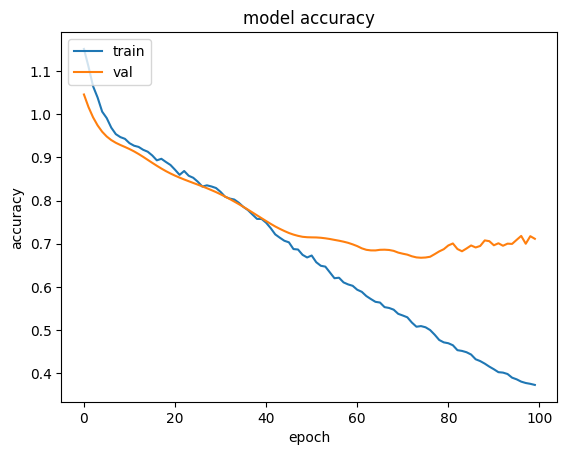

In [8]:
Trainer.tune_model(LSTM_type, LSTM_hp, Dev)

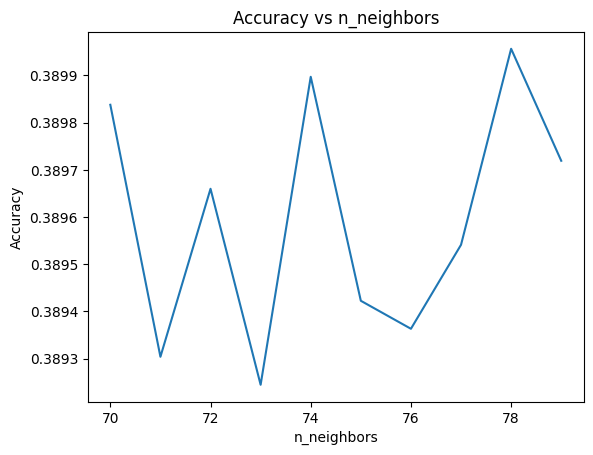

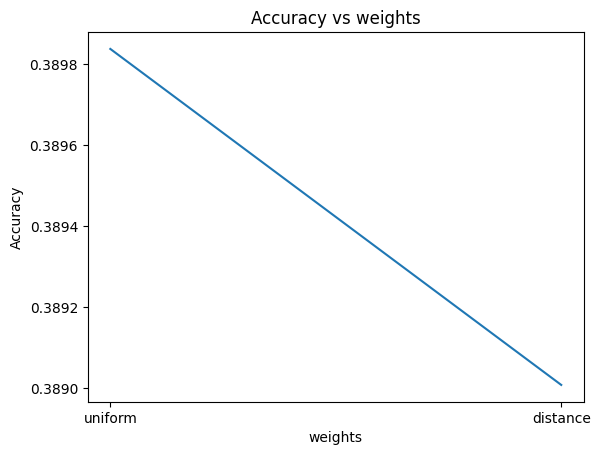

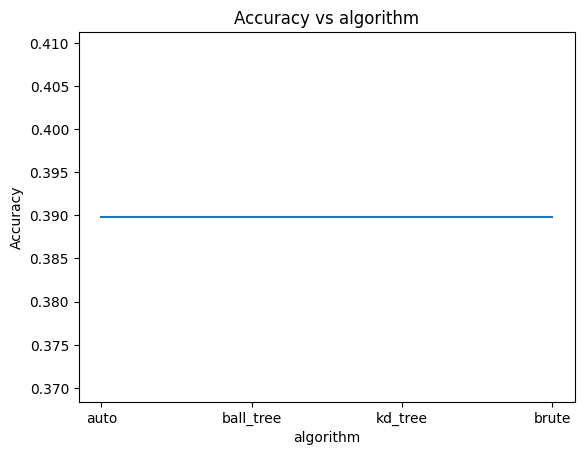

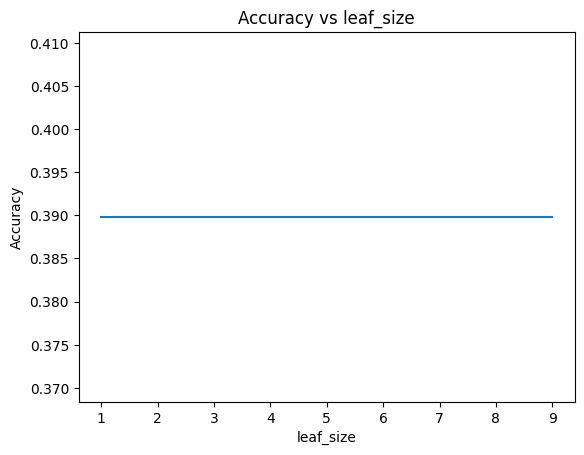

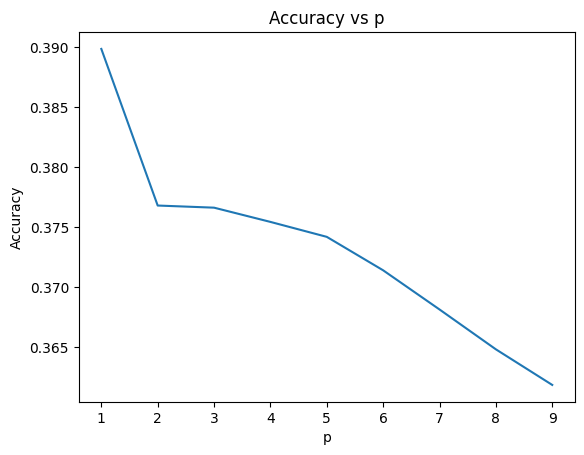

In [9]:
KNN_hp["n_neighbors"]["values"] = np.arange(start=70, stop=80, step=1)
KNN_hp["weights"]["values"] = ['uniform', 'distance']
KNN_hp["algorithm"]["values"] = ['auto', 'ball_tree', 'kd_tree', 'brute']
KNN_hp["leaf_size"]["values"] = np.arange(start=1, stop=10, step=1)
KNN_hp["p"]["values"] = np.arange(start=1, stop=10, step=1)
Trainer.tune_model(KNN_type, KNN_hp, Dev)



Random Forest model:


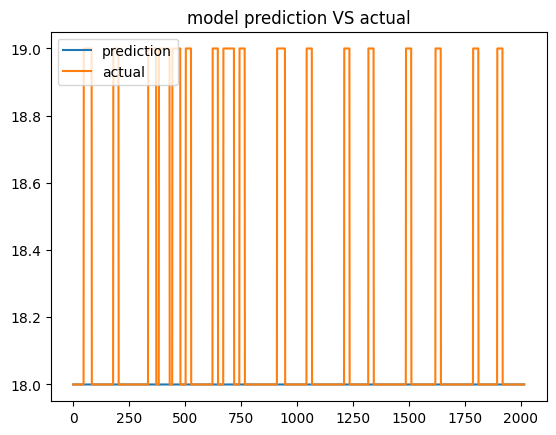

Validation accuracy: 0.10962883908454879
Test accuracy: 0.5421696748333847


LSTM model:
Epoch 1/100
1/1 - 2s - loss: 1.1505 - mean_absolute_error: 0.8229 - val_loss: 1.1591 - val_mean_absolute_error: 0.8750 - 2s/epoch - 2s/step
Epoch 2/100
1/1 - 0s - loss: 1.1096 - mean_absolute_error: 0.8051 - val_loss: 1.1197 - val_mean_absolute_error: 0.8563 - 55ms/epoch - 55ms/step
Epoch 3/100
1/1 - 0s - loss: 1.0769 - mean_absolute_error: 0.7881 - val_loss: 1.0851 - val_mean_absolute_error: 0.8389 - 52ms/epoch - 52ms/step
Epoch 4/100
1/1 - 0s - loss: 1.0397 - mean_absolute_error: 0.7704 - val_loss: 1.0548 - val_mean_absolute_error: 0.8226 - 51ms/epoch - 51ms/step
Epoch 5/100
1/1 - 0s - loss: 1.0060 - mean_absolute_error: 0.7556 - val_loss: 1.0289 - val_mean_absolute_error: 0.8071 - 52ms/epoch - 52ms/step
Epoch 6/100
1/1 - 0s - loss: 0.9968 - mean_absolute_error: 0.7501 - val_loss: 1.0069 - val_mean_absolute_error: 0.7923 - 54ms/epoch - 54ms/step
Epoch 7/100
1/1 - 0s - loss: 0.9705 - mean_absolute

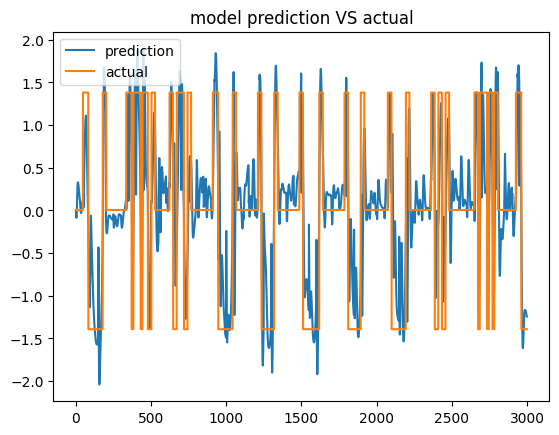

Validation accuracy: 0.7855109572410583
1/1 [==============================] - 0s 26ms/step - loss: 0.3679 - mean_absolute_error: 0.4104
Test accuracy: 0.41037124395370483


KNN model:


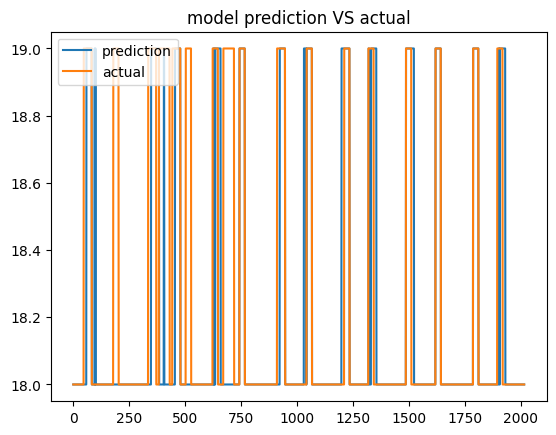

Validation accuracy: 0.39019328827226374
Test accuracy: 0.7913099162773047


In [10]:
"""
Train & Test Models
"""
RF_hp = {"max_features": {"values": [2], "index": 0}, "max_depth": {"values": [2], "index": 0}, "min_samples_split": {"values": [3], "index": 0}, "min_samples_leaf": {"values": [3], "index": 0}}
LSTM_hp = {"hyper_param_name": {"values": [], "index": 0}}
KNN_hp = {"n_neighbors": {"values": [90], "index": 0}, "weights": {"values": ['uniform'], "index": 0}, "algorithm": {"values": ['auto'], "index": 0}, "leaf_size": {"values": [1], "index": 0}, "p": {"values": [1], "index": 0}}
RF_model = Trainer.train_model(RF_type, RF_hp, Dev, Dev)
LSTM_model = Trainer.train_model(LSTM_type, LSTM_hp, Dev, Dev)
KNN_model = Trainer.train_model(KNN_type, KNN_hp, Dev, Dev)

user_type:  worker
noise_type:  large
pets:  True
plants:  False
insolation_time:  {'ac_temp': 0.20359847683775645, 'external_temp': 0.8006096767657267}
2/2 [==============================] - 0s 6ms/step


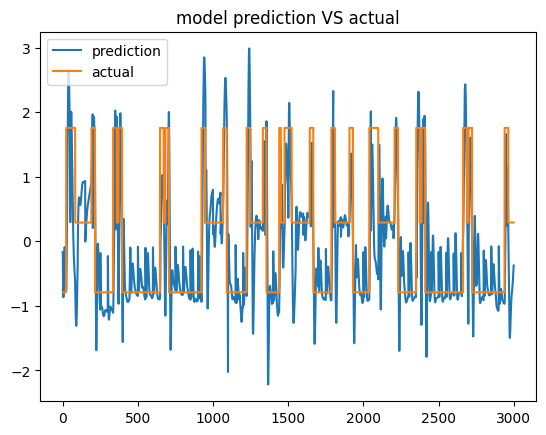

In [19]:
"""
2nd Prototype
"""
################################################################################
# user input: user profile
# AI (LSTM) input: External Temp, Internal Temp, Outside Humidity, user profile
# AI (LSTM) output: internal temperature to set AC
################################################################################

def plot_prediction(predictions, labels, time_range = "week"):
    time = {"day": 288, "week": 7*288, "month": 288*7*4, "year": 288*52*7}
    plt.plot(predictions[:time[time_range]].flatten())
    plt.plot(labels[:time[time_range]].flatten())
    plt.title('model prediction VS actual')
    plt.legend(['prediction', 'actual'], loc='upper left')
    plt.show()

def plot_results(model, user_type, noise_type, pets, plants, insolation_time_ac, insolation_time_external, schedule_cycle, time_range):
    processor = Data_Processor()
    user_profile = processor.gen_user_profile(user_type, noise_type, pets, plants, insolation_time_ac, insolation_time_external, schedule_cycle)
    print("user_type: ", user_profile["user_type"])
    print("noise_type: ", user_profile["noise_type"])
    print("pets: ", user_profile["pets"])
    print("plants: ", user_profile["plants"])
    print("insolation_time: ", user_profile["insolation_time"])
    data = processor.process_data("raw_data", user_profile, quick = True)
    predictions, labels = model.predict(data)
    plot_prediction(predictions, labels, time_range)

"""User Interface"""
# generate user profiles
user_type = None
noise_type = None
pets = None
plants = None
insolation_time_ac = None
insolation_time_external = None
schedule_cycle = None
plot_results(LSTM_model, user_type, noise_type, pets, plants, insolation_time_ac, insolation_time_external, schedule_cycle,time_range = "year")

In [ ]:

"""
1st Prototype
"""
################################################################################
# user input: warmer, colder, same
# AI (RF) input: internal temperature, external temperature, time, user input
# AI (RF) output: internal temperature to set AC
################################################################################
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import statistics
import matplotlib
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import sklearn
import os
import glob

# Imports all CSV files found in current working directory
path = os.getcwd()
txt_files = glob.glob(os.path.join(path, "*.TXT"))


def line_prepender(filename, line):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        if line not in content:
            f.write(line.rstrip('\r\n') + '\n' + content)


# Combines individual TXT's into one master data frame
for file in txt_files:
    temp = file.split("\\")
    line_prepender(temp[len(
        temp) - 1], "DATE,TIME,INTERNAL_TEMP,HUMIDITY,WALL_TEMP,AMBIENT_TEMP,COMFORT_LEVEL")
df_list = [pd.read_csv(f) for f in txt_files]
master_data = pd.concat(df_list)
print(str(len(df_list)), 'file(s) read')

clean_data = master_data.copy()
clean_data['DATE'] = clean_data['DATE'].astype(str)
clean_data['COMFORT_LEVEL'] = clean_data['COMFORT_LEVEL'].astype(str)
clean_data['INTERNAL_TEMP'] = [
    float(x.split('°')[0]) for x in clean_data['INTERNAL_TEMP']]
clean_data['HUMIDITY'] = [float(x.split('%')[0])
                          for x in clean_data['HUMIDITY']]
clean_data['WALL_TEMP'] = [float(x.split('°')[0])
                           for x in clean_data['WALL_TEMP']]
clean_data['AMBIENT_TEMP'] = [float(x.split('°')[0])
                              for x in clean_data['AMBIENT_TEMP']]

clean_data['TIME'] = [datetime.strptime(
    x, '%H:%M:%S').time() for x in clean_data['TIME']]
clean_data['TIME_CATEGORICAL'] = [
    (x.hour % 24 + 4) // 4 for x in clean_data['TIME']]
clean_data['TIME_CATEGORICAL'].replace({1: 'Late Night',
                                        2: 'Early Morning',
                                        3: 'Morning',
                                        4: 'Noon',
                                        5: 'Evening',
                                        6: 'Night'},
                                       inplace=True)

clean_data = clean_data[~(clean_data == 0).any(axis=1)]
clean_data

clean_data.corr()

clean_data['INTERNAL_TEMP'].hist()
clean_data['WALL_TEMP'].hist()
clean_data['AMBIENT_TEMP'].hist()
clean_data['HUMIDITY'].hist()
clean_data['TIME_CATEGORICAL'].hist()

#! pip install xgboost


X = clean_data.drop(columns=['COMFORT_LEVEL', 'TIME', 'DATE'], axis=0)
y = clean_data['COMFORT_LEVEL']

X['TIME_CATEGORICAL'] = X['TIME_CATEGORICAL'].astype("category")
X['TIME_CATEGORICAL'] = X['TIME_CATEGORICAL'].cat.codes
y = y.astype('category')
y = y.cat.codes

X
X.corr()
y
X.hist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
np.random.seed(2021)
idx_validacion = np.random.choice(
    X_train.shape[0],
    size=int(X_train.shape[0] * 0.1),
    replace=False
)
X_val = X_train.iloc[idx_validacion, :].copy()
y_val = y_train.iloc[idx_validacion].copy()
fit_params = {"early_stopping_rounds": 5,
              "eval_metric": "mlogloss",
              "eval_set": [(X_val, y_val)],
              "verbose": 1
              }
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train, **fit_params)
y_pred = model_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
feature_important = model_xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=[
                    "score"]).sort_values(by="score", ascending=False)
data.plot(kind='barh')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
np.random.seed(2021)
idx_validacion = np.random.choice(
    X_train.shape[0],
    size=int(X_train.shape[0] * 0.1),
    replace=False
)
X_val = X_train.iloc[idx_validacion, :].copy()
y_val = y_train.iloc[idx_validacion].copy()
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
